In [2]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from plotly import graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [3]:
df = pd.read_csv('events.csv')

### 데이터 형태 파악하기

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [5]:
df.describe()

,product_id,category_id,price,user_id
count,8.851290e+05,8.851290e+05,885129.000000,8.851290e+05
mean,1.906621e+06,2.144423e+18,146.328713,1.515916e+18
std,1.458708e+06,6.165105e+14,296.807683,3.747287e+07
min,1.020000e+02,2.144416e+18,0.220000,1.515916e+18
25%,6.988030e+05,2.144416e+18,26.460000,1.515916e+18
50%,1.452883e+06,2.144416e+18,65.710000,1.515916e+18
75%,3.721194e+06,2.144416e+18,190.490000,1.515916e+18
max,4.183880e+06,2.227847e+18,64771.060000,1.515916e+18


In [6]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


### event type 종류 확인

In [7]:
set(df['event_type'])

{'cart', 'purchase', 'view'}

### datetime 데이터 유형 변환

In [8]:
df['datetime'] = pd.to_datetime(df['event_time'])

### 월별 접속 세션 수

In [9]:
df['month'] = df['datetime'].dt.strftime('%Y-%m')
monthly_sessions = df.groupby(by='month')['user_session'].count().reset_index()

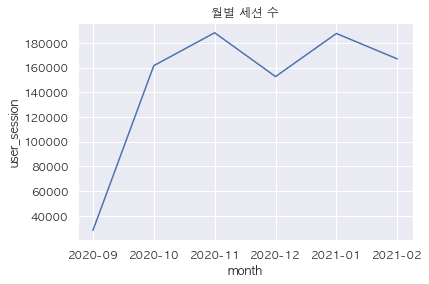

In [41]:
sns.set(style='darkgrid')
plt.rc('font', family='AppleGothic' ) #한글 폰트 설정
plt.title('월별 세션 수')
sns.lineplot(monthly_sessions['month'], monthly_sessions['user_session'])
plt.savefig('plots/monthly_sessions.png')

In [11]:
#월별 주문 건수
df_purchase = df[df.event_type=='purchase']
monthly_orders = df_purchase.groupby(by='month')['product_id'].count().reset_index()

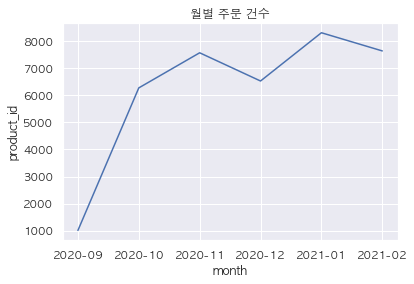

In [39]:
plt.title('월별 주문 건수')
sns.lineplot(monthly_orders['month'], monthly_orders['product_id'])
plt.savefig('plots/monthly_orders.png')

### 건단가

In [13]:
price_per_order = df_purchase.groupby(by='month')['price'].mean().reset_index()

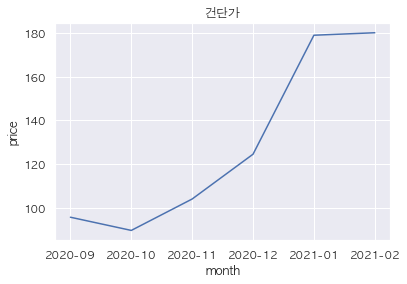

In [38]:
plt.title('건단가')
sns.lineplot(price_per_order['month'], price_per_order['price'])
plt.savefig('plots/price_per_orders.png')

### MAU
* 1회 이상 구매한 회원을 active한 이용자로 정의함.

In [15]:
df_purchase_users = df_purchase[['month', 'user_id']].drop_duplicates() #1회 이상 구입한 회원 목록
mau = df_purchase_users.groupby(by='month')['user_id'].count().reset_index()

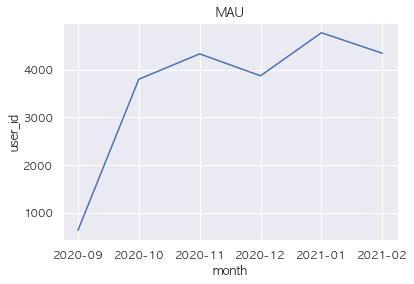

In [42]:
plt.title('MAU')
sns.lineplot(mau['month'], mau['user_id'])
plt.savefig('plots/monthly_active_users.png')

### 이탈율(bounce rate) 분석

In [17]:
view_cnt_per_session = pd.pivot_table(df, index=['user_session', 'user_id'], values= ['event_time', 'datetime'], aggfunc={'event_time': 'count', 'datetime':min}).reset_index()
view_cnt_per_session['month'] = view_cnt_per_session['datetime'].dt.strftime('%Y-%m')

In [18]:
view_cnt_per_session['bounced'] = view_cnt_per_session.event_time == 1
view_cnt_per_session['bounced'] = view_cnt_per_session['bounced'].astype(int)

In [19]:
bounced = pd.pivot_table(view_cnt_per_session, index='month', columns='bounced', aggfunc={'count'})['datetime']

In [20]:
bounced = bounced.reset_index(col_level=1)
bounced = bounced.droplevel(axis=1,level=0)
bounced = bounced.rename(columns={0:'bounced', 1:'not_bounced'})

In [21]:
bounced['bounced_rate'] = bounced['bounced'] / ( bounced['bounced'] + bounced['not_bounced'] ) * 100

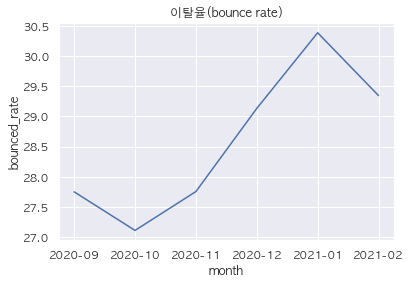

In [43]:
plt.title('이탈율(bounce rate)')
sns.lineplot(x=bounced['month'], y=bounced['bounced_rate'])
plt.savefig('plots/bounce_rate.png')

* 이탈률이 증가하는 추세임.
* 유저들이 어떻게 유입됐는지 알 수 있으면 이탈 요인 분석할 수 있을 듯

### 코호트 분석
* 첫 접속일을 기준으로 코호트 분석
* 매달 재접속 여부로 유지율 집계

In [23]:
cohort_month = pd.DataFrame(df.groupby(by='user_id')['month'].min()).reset_index()

In [24]:
cohort_month = cohort_month.rename(columns={'month':'cohort'})

In [25]:
df_cohort = pd.merge(df, cohort_month, on='user_id', how='left')

In [26]:
df_cohort_re = df_cohort[['cohort', 'month', 'user_id']].drop_duplicates()

In [27]:
cohort_retention = pd.DataFrame(df_cohort_re.groupby(by=['cohort', 'month'])['user_id'].count()).reset_index()

In [28]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df))
    return df

cohort_retention_re = cohort_retention.groupby(by='cohort').apply(cohort_period)

In [29]:
cohort_retention_re.set_index(['cohort', 'CohortPeriod'], inplace=True)

In [30]:
cohort_retention_unstack = cohort_retention_re[['user_id']].unstack(level=0)

In [31]:
cohort_size = cohort_retention_unstack.T[0]

In [32]:
cohort_retention_unstack_re = cohort_retention_unstack.divide(cohort_size, axis=1)

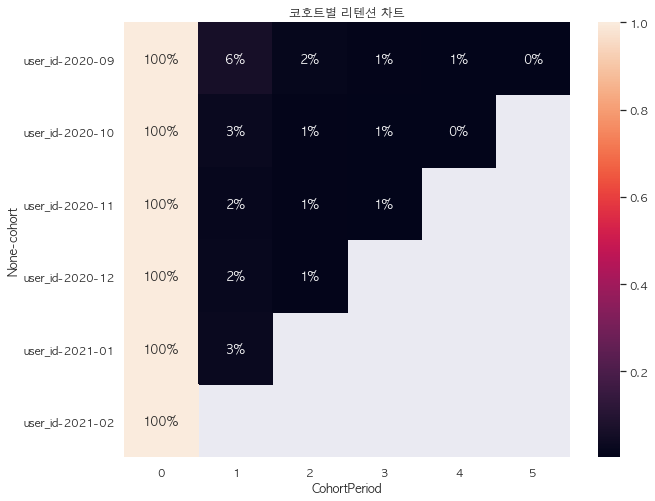

In [45]:
plt.figure(figsize=(10,8))
plt.rc('font', family='AppleGothic' ) #한글 폰트 설정
#plt.rc('font', family='Malgun Gothic' )
plt.title('코호트별 리텐션 차트')
sns.heatmap(cohort_retention_unstack_re.T, mask=cohort_retention_unstack_re.T.isnull(), annot=True, fmt='.0%')
plt.savefig('plots/cohort_analysis.png')